In [1]:
device = "cuda"

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = np.load("dataset/terrain_dataset.npy").astype(np.float32)
data -= np.mean(data)
data /= np.std(data)

data = torch.from_numpy(data).float().to(device)


## Model Definitions

In [4]:
class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x, embeddings):
        x = x + embeddings[:, :x.shape[1], None, None]
        r = self.conv1(self.relu(x))
        r = self.conv2(self.relu(r))
        return x + r

In [5]:
class UNetLayer(nn.Module):
    def __init__(self, upscale, in_channels, out_channels):
        super().__init__()
        
        self.res1 = ResBlock(in_channels)
        self.res2 = ResBlock(in_channels)

        if upscale:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        else:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
    
    def forward(self, x, embeddings):
        x = self.res1(x, embeddings)
        x = self.res2(x, embeddings)
        return self.conv(x), x

In [6]:
class UNET(nn.Module):
    def __init__(self, time_steps = 256):
        super().__init__()
        self.shallow_conv = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        
         # Downsampling
        self.layer1 = UNetLayer(False, 32, 64)
        self.layer3 = UNetLayer(False, 64, 128)
        self.layer4 = UNetLayer(False, 128, 256)

        # Upsampling
        self.layer5 = UNetLayer(True, 256, 128)
        self.layer6 = UNetLayer(True, 128, 64)
        self.layer7 = UNetLayer(True, 64, 32)

        # Final convolution
        self.final_conv = nn.Conv2d(32, 1, kernel_size=3, padding=1)

        self.embeddings = nn.Embedding(time_steps, 256)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, t):
        x = self.shallow_conv(x)
        residuals = []

        for layer in [self.layer1, self.layer3, self.layer4]:
            embeddings = self.embeddings(t)
            x, r = layer(x, embeddings)
            residuals.append(r)
        
        for i, layer in enumerate([self.layer5, self.layer6, self.layer7]):
            x = layer(x, self.embeddings(t))[0] + residuals[-i-1]
        
        return self.final_conv(self.relu(x))

In [7]:
class DDPM_Scheduler(nn.Module):
    def __init__(self, time_steps = 256):
        super().__init__()
        self.beta = torch.linspace(0.0001, 0.02, time_steps, requires_grad=False).to(device)
        alpha = 1 - self.beta
        self.alpha = torch.cumprod(alpha, dim=0).requires_grad_(False).to(device)
    
    def forward(self, t):
        return self.beta[t], self.alpha[t]

    def set_seed(self, seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        np.random.seed(seed)

## Train the Model

In [17]:
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-5
TIME_STEPS = 256

train_dataset = torch.utils.data.TensorDataset(data)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

scheduler = DDPM_Scheduler(time_steps=TIME_STEPS)
#model = UNET(time_steps=TIME_STEPS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss(reduction="mean")

for e in range(EPOCHS):
    total_loss = 0
    for batch_id, (batch_x, ) in enumerate(train_loader):
        batch_x = batch_x.to(device)
        batch_x = batch_x.unsqueeze(1)
        batch_size = batch_x.shape[0]
        
        t = torch.randint(0, TIME_STEPS, (batch_size,), device=device)
        alpha = scheduler.alpha[t].view(batch_size, 1, 1, 1)
        noise = torch.randn_like(batch_x)
        noisy_x = torch.sqrt(alpha) * batch_x + torch.sqrt(1 - alpha) * noise
        output = model(noisy_x, t)

        optimizer.zero_grad()
        loss = loss_fn(output, noise)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
        print(f"Epoch {e+1}/{EPOCHS}, Batch {batch_id+1}/{len(train_loader)}, Loss: {loss.item():.4f}")


Epoch 1/10, Batch 1/2043, Loss: 0.0093
Epoch 1/10, Batch 2/2043, Loss: 0.0127
Epoch 1/10, Batch 3/2043, Loss: 0.0142
Epoch 1/10, Batch 4/2043, Loss: 0.0145
Epoch 1/10, Batch 5/2043, Loss: 0.0244
Epoch 1/10, Batch 6/2043, Loss: 0.0154
Epoch 1/10, Batch 7/2043, Loss: 0.0143
Epoch 1/10, Batch 8/2043, Loss: 0.0169
Epoch 1/10, Batch 9/2043, Loss: 0.0131
Epoch 1/10, Batch 10/2043, Loss: 0.0160
Epoch 1/10, Batch 11/2043, Loss: 0.0131
Epoch 1/10, Batch 12/2043, Loss: 0.0205
Epoch 1/10, Batch 13/2043, Loss: 0.0162
Epoch 1/10, Batch 14/2043, Loss: 0.0173
Epoch 1/10, Batch 15/2043, Loss: 0.0193
Epoch 1/10, Batch 16/2043, Loss: 0.0140
Epoch 1/10, Batch 17/2043, Loss: 0.0169
Epoch 1/10, Batch 18/2043, Loss: 0.0135
Epoch 1/10, Batch 19/2043, Loss: 0.0276
Epoch 1/10, Batch 20/2043, Loss: 0.0132
Epoch 1/10, Batch 21/2043, Loss: 0.0142
Epoch 1/10, Batch 22/2043, Loss: 0.0111
Epoch 1/10, Batch 23/2043, Loss: 0.0265
Epoch 1/10, Batch 24/2043, Loss: 0.0223
Epoch 1/10, Batch 25/2043, Loss: 0.0135
Epoch 1/1

KeyboardInterrupt: 

tensor([[[[0.9800]]]], device='cuda:0')


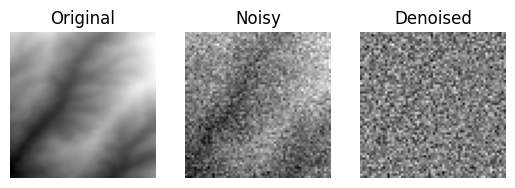

In [25]:
model.eval()
with torch.no_grad():
    t = torch.randint(0, TIME_STEPS, (1,), device=device)
    alpha = scheduler.alpha[t].view(1, 1, 1, 1)
    noise = torch.randn(1, 1, 64, 64, device=device)
    print(alpha)
    noisy_x = torch.sqrt(alpha) * data[0].unsqueeze(0).unsqueeze(0) + torch.sqrt(1 - alpha) * noise
    output = model(noisy_x, t)
    output = output.squeeze(0).squeeze(0).cpu().numpy()

    noisy_x = noisy_x.squeeze(0).squeeze(0).cpu().numpy()
    original = data[0].cpu().numpy()

    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap="gray")
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(noisy_x, cmap="gray")
    plt.title("Noisy")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(output, cmap="gray")
    plt.title("Denoised")
    plt.axis("off")

    plt.show()
    